### 1. Importing packages

In [ ]:
!pip install shap

In [ ]:
# data manipulation
import pandas as pd
import numpy as np

# removing warning about setting value on copy of slice
pd.options.mode.chained_assignment = None

# displaying up to 60 columns of dataframe
pd.set_option('display.max_columns', 60)

# matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# setting font size
plt.rcParams['font.size'] = 24

# internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# seaborn for visualization
import seaborn as sns
sns.set(font_scale=1)

# machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import shap

### 2. Loading dataset

In [ ]:
credit_df = pd.read_csv('credit-data.csv')
credit_df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [ ]:
credit_df.shape

(100514, 19)

In [ ]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

### 3. Feature engineering

In [ ]:
credit_df.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

In [ ]:
# function for calculating null values by column
def calc_null_vals(df):
    null_vals = df.isnull().sum() # total null values
    null_vals_perc = 100 * null_vals / len(df) # percentage of null values
    null_vals_df = pd.concat([null_vals, null_vals_perc], axis=1)
    null_vals_df.rename(columns={0:'Null Vals', 1:'% of Total Vals'}, inplace=True)
    null_vals_df = null_vals_df[null_vals_df.iloc[:,1] != 0].sort_values('% of Total Vals', 
                                                                            ascending=False).round(1)
    print(f'Columns: {df.shape[1]}')
    print(f'Columns with null vals: {null_vals_df.shape[0]}')
    return null_vals_df

In [ ]:
calc_null_vals(credit_df)

Columns: 17
Columns with null vals: 17


,Null Vals,% of Total Vals
Months since last delinquent,53655,53.4
Credit Score,19668,19.6
Annual Income,19668,19.6
Years in current job,4736,4.7
Bankruptcies,718,0.7
Tax Liens,524,0.5
Maximum Open Credit,516,0.5
Current Credit Balance,514,0.5
Number of Credit Problems,514,0.5
Number of Open Accounts,514,0.5


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


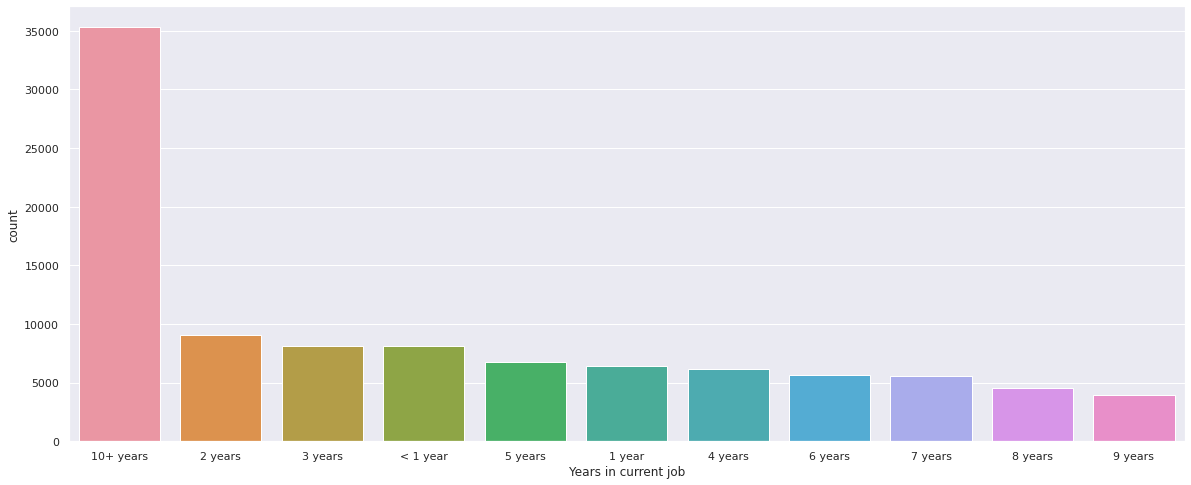

In [ ]:
# dropping column with > 50% null values
credit_df.drop(columns='Months since last delinquent', axis=1, inplace=True)

# last 514 rows are null
credit_df.drop(credit_df.tail(514).index, inplace=True) # dropping last 514 rows

# number of null values is very low in 'Maximum Open Credit', 'Tax Liens', 'Bankruptcies'
for row in credit_df['Maximum Open Credit'][credit_df['Maximum Open Credit'].isnull() == True].index:
    credit_df.drop(labels=row, inplace=True)

for row in credit_df['Tax Liens'][credit_df['Tax Liens'].isnull() == True].index:
    credit_df.drop(labels=row, inplace=True)

for row in credit_df['Bankruptcies'][credit_df['Bankruptcies'].isnull() == True].index:
    credit_df.drop(labels=row, inplace=True)

credit_df.fillna(credit_df.mean(), inplace=True) # filling null values with means (numerical)
credit_df.fillna('10+ years', inplace=True) # filling null values with '10+ years' (categorical)

plt.figure(figsize=(20,8))
sns.countplot(credit_df['Years in current job'], order=credit_df['Years in current job'].value_counts().index)

In [ ]:
calc_null_vals(credit_df)

Columns: 16
Columns with null vals: 0


,Null Vals,% of Total Vals


In [ ]:
# one hot encoding categorical columns
cat_cols = ['Term', 'Years in current job', 'Home Ownership', 'Purpose']
credit_df = pd.get_dummies(data=credit_df, columns=cat_cols)

In [ ]:
# function for removing collinear features
def remove_collinear_features(X, threshold):
    y = X['Loan Status']
    X.drop(columns='Loan Status', inplace=True)

    # calculating correlation matrix
    corr_matrix = X.corr()
    itr = range(len(corr_matrix.columns)-1)
    drop_cols = []

    # iterating over correlation matrix and comparing correlations
    for i in itr:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            if val >= threshold:
                print(col.values[0], '|', row.values[0], '|', round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # dropping one of each pair of correlated columns
    drop_cols_set = set(drop_cols)
    X.drop(columns=drop_cols_set, inplace=True)

    # adding score back
    X['Loan Status'] = y

    return X

In [ ]:
credit_df = remove_collinear_features(credit_df, 0.6)

Bankruptcies | Number of Credit Problems | 0.75
Home Ownership_Rent | Home Ownership_Home Mortgage | 0.83
Purpose_Take a Trip | Home Ownership_HaveMortgage | 0.61


In [ ]:
credit_df.shape

(99794, 42)

### 4. XGBoost classification

In [ ]:
# splitting dataset into training and testing sets
features = credit_df.drop(columns='Loan Status')
response = pd.DataFrame(credit_df['Loan Status'])
X_train, X_test, y_train, y_test = train_test_split(features, response, 
                                                    test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79835, 41)
(19959, 41)
(79835, 1)
(19959, 1)


In [ ]:
# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
# function for performance evaluation
def model_perf(model, X, y):
    # k-fold cross validation
    cvs = cross_val_score(model, X, y, cv=5)
    return cvs.mean()

# function for fitting and evaluating model
def model_fit_eval(model, X_train, X_test):
    model.fit(X_train, y_train)
    cvs_train = model_perf(model, X_train, y_train)
    cvs_test = model_perf(model, X_test, y_test)
    return cvs_train, cvs_test

In [ ]:
# fitting and evaluating model
xgb_c = XGBClassifier()
cvs_train, cvs_test = model_fit_eval(xgb_c, X_train, X_test)
print(cvs_train)
print(cvs_test)

0.8197657668942193
0.8172752922532613


In [ ]:
# feature importances
feature_imp_df = pd.DataFrame({'Feature':list(features.columns), 
                               'Importance':xgb_c.feature_importances_})

# top 10 most important features
feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_imp_df['Rank'] = np.arange(1, len(feature_imp_df)+1, 1)
feature_imp_rank_df = feature_imp_df.set_index('Rank')
feature_imp_rank_df = feature_imp_rank_df[['Feature', 'Importance']]
feature_imp_rank_df.head(10)

,Feature,Importance
Rank,,
1,Credit Score,0.371498
2,Current Loan Amount,0.207109
3,Term_Long Term,0.145201
4,Annual Income,0.059634
5,Home Ownership_Home Mortgage,0.045661
6,Maximum Open Credit,0.022083
7,Purpose_Business Loan,0.021131
8,Current Credit Balance,0.020520
9,Purpose_small_business,0.020448


In [ ]:
# using top 10 most important features to fit and evaluate model
top_features_df = feature_imp_rank_df['Feature'][:10]
top_features = [list(features.columns).index(c) for c in top_features_df]
X_train1 = X_train[:,top_features]
X_test1 = X_test[:,top_features]

In [ ]:
xgb_c1 = XGBClassifier()
cvs_train1, cvs_test1 = model_fit_eval(xgb_c1, X_train1, X_test1)
print(cvs_train1)
print(cvs_test1) # improvement from xgb_c

0.8197657668942193
0.8174757181614545


### 5. Explaining with Shapely

In [ ]:
# creating X train dataframe
X_train = pd.DataFrame(X_train)
X_train.columns = features.columns
X_train.rename(columns={'Years in current job_< 1 year':'Years in current job less than a year'}, inplace=True)

In [ ]:
# loading JS visualization to notebook
shap.initjs()

# explaining model's predictions with SHAP values
explainer = shap.TreeExplainer(xgb_c)
shap_values = explainer.shap_values(X_train)

# visualizing first prediction's explanation
shap.force_plot(explainer.expected_value, 
                shap_values[14,:], 
                X_train.iloc[14,:])

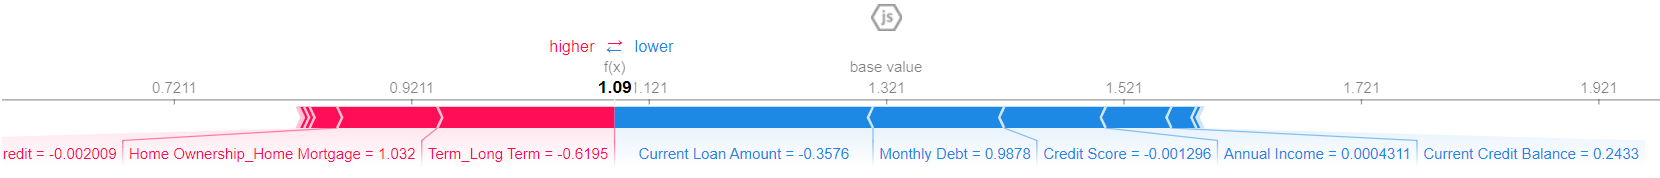

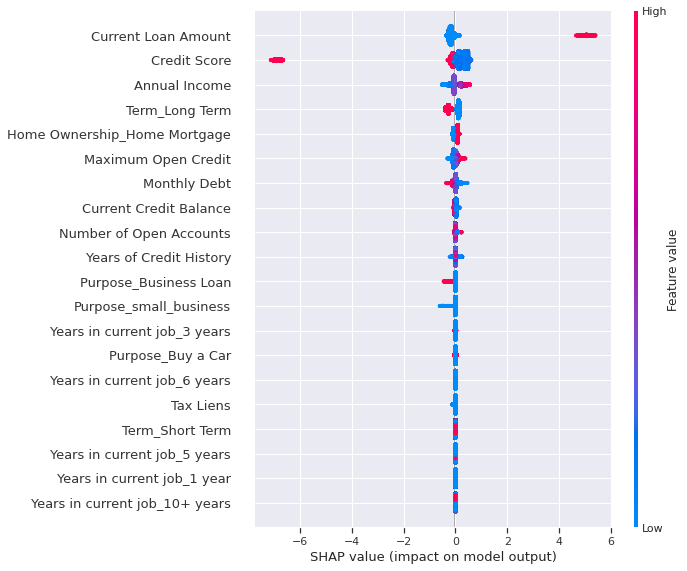

In [ ]:
# summarizing effects of features
shap.summary_plot(shap_values, X_train)

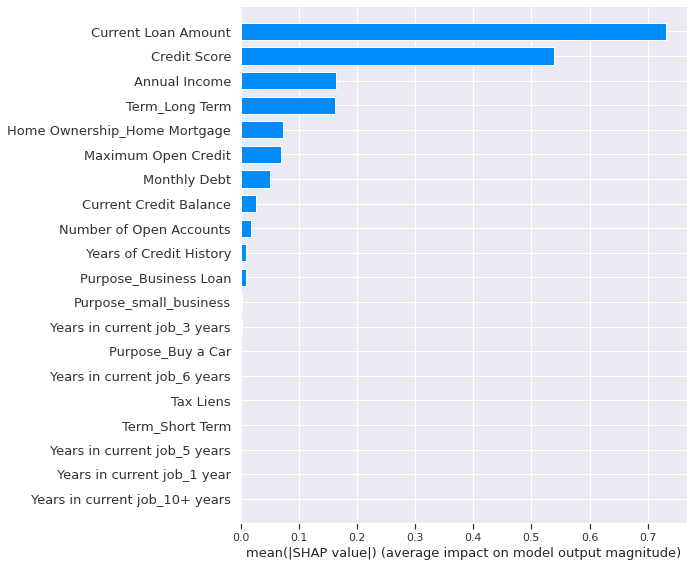

In [ ]:
# summarizing importances of features
shap.summary_plot(shap_values, X_train, plot_type='bar')